In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.datasets.mldata import fetch_mldata
import tempfile

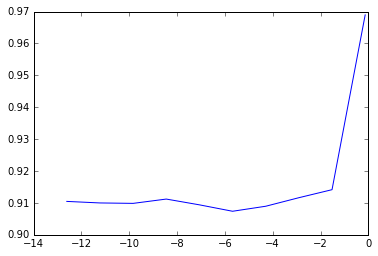

In [80]:
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

ne = 10000;
n = 2*ne;
d = 10;
steps = 10
max_dots = np.zeros(steps)
margins = np.zeros(steps)
for i in range(10):
    margin = 3.5*pow(4,-i-1)
    margins[i] = margin
    pivot = np.ones(d)
    nc = 0
    X = np.zeros((n,d))
    y = np.zeros(n)
    while True: 
        rv = np.random.normal(1,1,d)
       # rv = rv/np.linalg.norm(rv)
        if np.dot(rv,pivot)/(np.linalg.norm(rv)*np.linalg.norm(pivot)) > margin:
            X[nc,:] = rv
           # print(np.dot(rv,pivot))
            y[nc] = 1
            #ax.scatter(X[nc,0], X[nc,1], X[nc,2], c='b', marker='o')
            nc = nc + 1      
        if nc == ne: 
            break

    while True: 
        rv = np.random.normal(-1,1,d)
       # rv = rv/np.linalg.norm(rv)
        if np.dot(rv,pivot)/(np.linalg.norm(rv)*np.linalg.norm(pivot)) < -margin:
            X[nc,:] = rv
            y[nc] = -1
            #ax.scatter(X[nc,0], X[nc,1], X[nc,2], c='r', marker='o')
            nc = nc + 1
        if nc == n: 
            break
    [U, s, V] = np.linalg.svd(X, full_matrices= False)
    dots = np.dot(np.transpose(U),y/np.linalg.norm(y))
    max_dots[i] = dots[1]*dots[1] + dots[0]*dots[0]
plt.plot(np.log(margins),max_dots)

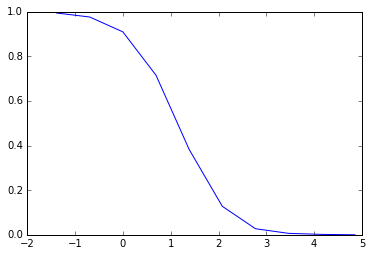

In [83]:
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

ne = 10000;
n = 2*ne;
d = 10;
steps = 10
max_dots = np.zeros(steps)
var_s = np.zeros(steps)
for i in range(10):
    var = 0.25*pow(2,i)
    var_s[i] = var
    pivot = np.ones(d)
    nc = 0
    X = np.zeros((n,d))
    y = np.zeros(n)
    while True: 
        rv = np.random.normal(1,var,d)
       # rv = rv/np.linalg.norm(rv)
        X[nc,:] = rv
        y[nc] = 1
        nc = nc + 1      
        if nc == ne: 
            break

    while True: 
        rv = np.random.normal(-1,var,d)
       # rv = rv/np.linalg.norm(rv)
        X[nc,:] = rv
        y[nc] = -1
        nc = nc + 1
        if nc == n: 
            break
    [U, s, V] = np.linalg.svd(X, full_matrices= False)
    dots = np.dot(np.transpose(U),y/np.linalg.norm(y))
    max_dots[i] = dots[1]*dots[1] + dots[0]*dots[0]
plt.plot(np.log(var_s),max_dots)

In [9]:
import operator

def w_alpha(alpha,X,lambd,verbose=False): # check the equation 3 of (SDCA) paper
    n, d = X.shape
    w = np.zeros(d)
    for i in range(n): 
        w = w + alpha[i]*X[i,:]/lambd
    w = w/n
    return w

def primal_func(w,y,X,lambd,verbose=False): # computes the primal value for the given parameter w
    n, d = X.shape
    pw = 0
    for i in range(n): 
        if verbose:
            print("P({}):y={},dot={},delta_pw={}".format(i,y[i],np.dot(w,X[i,:]),max(0,1-y[i]*np.dot(w,X[i,:]))))
        pw = pw + max(0,1-y[i]*np.dot(w,X[i,:]))
    pw = pw/n 
    pw = pw + 0.5*lambd*np.square(np.linalg.norm(w))
    return pw

def dual_func(alpha,y,X,lambd,verbose=False): # computes the dual function value for a given parameter alpha 
    da = 0
    n, d = X.shape
    for i in range(n): 
        if alpha[i]*y[i] <= 1 and alpha[i]*y[i] >= 0:
            da = da + alpha[i]*y[i]
        else:
            da = da + float("inf")
    da = da / n 
    da = da - 0.5*lambd*np.square(np.linalg.norm(w_alpha(alpha,X,lambd)))
    return da 


def sortbyindeces(a):
  return [i[0] for i in sorted(enumerate(a), key=lambda a:a[1],reverse=True)]

def SVM_SDCA(y, X, lambd, num_steps, T0, verbose=False):
  # y_n \in {-1,1} is target,
  # X_{n \time d}: is the row-wise arrange of observations , so each observation has dimension d 
  # Please note that this implementation just includes the output averaging option with paramter T0
  if verbose:
    print("Stochastic coordinate Ascent for SVM")
  inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(X, axis=1)))
  n, d = X.shape
  # it might be better to change initial value of alpha 
  alpha = np.zeros(n)
  #setting w(alpha_0)
  w = w_alpha(alpha,X,lambd)
  duals = np.zeros(num_steps)# dual function values per iteration
  primals = np.zeros(num_steps) #primal function values per iteration 
  if verbose:
    primal_value = primal_func(w,y,X,lambd)
    dual_value = dual_func(alpha,y,X,lambd)
    print("  Initial primal objective value: {}, Intial dual objective value: {}".format(primal_value, dual_value))
  w_bar = np.zeros(d)
  T_T0 = 0
  alpha_bar = np.zeros(n)
  for cur_step in range(num_steps):
    # pick a random dual coordinate
    ii = np.random.randint(0, n)
    alpha_i_old = alpha[ii]
    xi = X[ii,:]
    yi = y[ii]
    inv_sqi = inv_sq_row_norms[ii]
    # coordinate update step 
    delta_alpha_i = yi*max(0,min(1,(lambd*n*(1-yi*np.dot(xi,w))*inv_sqi)+alpha_i_old*yi)) - alpha_i_old
    # update the dual and primal paramters
    alpha[ii] = alpha[ii] + delta_alpha_i
    w = w + delta_alpha_i*xi/(lambd*n)
    
    # output averaging 
    if cur_step > T0:
       w_bar = w_bar + w
       alpha_bar = alpha_bar + alpha
       T_T0 = T_T0 +1 
    
    duals[cur_step] = dual_func(alpha,y,X,lambd)
    primals[cur_step] = primal_func(w,y,X,lambd)
    if verbose: #and cur_step % n == 0 and cur_step > 0
      print("step:{},primal: {},dual: {}\n".format(cur_step,primals[cur_step], duals[cur_step] ))
  return (w_bar/T_T0, alpha_bar/T_T0 ,primals,duals)

def SVM_SteepestDualGradient_DCA(y, X, lambd, num_steps, T0, verbose=False): 
  # Computes the gradient of dual function and updates the coordinate with maximum absolute gradient value 
  # y_n \in {-1,1} is target,
  # X_{n \time d}: is the row-wise arrange of observations , so each observation has dimension d 
  # Please note that this implementation just includes the output averaging option with paramter T0
  if verbose:
    print("Steepest Dual Gradient Coordinate Ascent for SVM")
  inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(X, axis=1)))
  n, d = X.shape
  for i in range(n): 
    X[i,
  # it might be better to change initial value of alpha 
  alpha = np.zeros(n)
  #setting w(alpha_0)
  w = w_alpha(alpha,X,lambd)
  duals = np.zeros(num_steps)# dual function values per iteration
  primals = np.zeros(num_steps) #primal function values per iteration 
 
  if verbose:
    primal_value = primal_func(w,y,X,lambd)
    dual_value = dual_func(alpha,y,X,lambd)
    print("Initial primal objective value: {}, Intial dual objective value: {}".format(primal_value, dual_value))
  w_bar = np.zeros(d)
  T_T0 = 0
  alpha_bar = np.zeros(n)
  posinds = [j for j, e in enumerate(y) if e > 0]
  neginds = [kj for kj, e in enumerate(y) if e < 0]
  for cur_step in range(num_steps): 
    # Compute all delta alphas 
    #delta_alphas = np.multiply(y,np.maximum(0,np.minimum(1,(lambd*n*np.multiply((1-np.multiply(y,np.dot(X,w))),inv_sq_row_norms))+np.multiply(alpha,y))))-alpha
    
    # Compute the gradient 
    prods = np.dot(X,w)
    arcoss = 180*np.arccos(prods*np.sqrt(inv_sq_row_norms)/np.linalg.norm(w))/math.pi
    g_alpha = 1 - y*prods
    cosines = np.dot(X,w)/(np.linalg.norm(X, axis=1)*np.sqrt(np.square(np.linalg.norm(w))))
    avg_ang = np.average(arcoss)
    max_ang = max(arcoss)
    min_ang = min(arcoss)
    # Sort indeces in descent order of the gradient
    inds = sortbyindeces(g_alpha)
    ii = inds[0]
    # Choose the maximum coordinate which doesn't vailate the constratins for the update step 
    for i in range(len(g_alpha)): 
        j = inds[i]
        if (alpha[j]> 0 and alpha[j]<1) or ((alpha[j] == 0) and (g_alpha[j]*y[j] >= 0)) or ((alpha[j] == 1) and (g_alpha[j]*y[j] <= 0)):
            ii = j
           # print("OKKKKKK: alpha = {}, gradient = {},prod = {}".format(alpha[j],g_alpha[j],prods[j]))
            break
      #  else: 
           # print("####: alpha = {}, gradient = {},prod = {}".format(alpha[j],g_alpha[j],prods[j]))
                  
    # update the coordinate exactly same as SDCA
    alpha_i_old = alpha[ii]
    xi = X[ii,:]
    yi = y[ii]
    inv_sqi = inv_sq_row_norms[ii]
    # coordinate update step 
    delta_alpha_i = yi*max(0,min(1,(lambd*n*(1-yi*np.dot(xi,w))*inv_sqi)+alpha_i_old*yi)) - alpha_i_old
    # update the dual and primal paramters
    alpha[ii] = alpha[ii] + delta_alpha_i
    w = w + delta_alpha_i*xi/(lambd*n)
 #   print("\n---------new alpha[{}] = {}\n".format(ii,alpha[ii]))
    # output averaging 
    if cur_step > T0:
       w_bar = w_bar + w
       alpha_bar = alpha_bar + alpha
       T_T0 = T_T0 +1 
    
    duals[cur_step] = dual_func(alpha,y,X,lambd)
    primals[cur_step] = primal_func(w,y,X,lambd)
    if verbose: #and cur_step % n == 0 and cur_step > 0
      print("step:{},primal: {},dual: {},alpha({}) = {}, avg angle = {}, max angle = {}, min angle = {},w = {} \n".format(cur_step,primals[cur_step], duals[cur_step],ii,alpha[ii],avg_ang,max_ang,min_ang,w ))
  return (w_bar/T_T0, alpha_bar/T_T0 ,primals,duals)

def SVM_LSHSIM_DCA(y, X, lambd, num_steps, T0, verbose=False): 
  # Computes the gradient of dual function and updates the coordinate with maximum absolute gradient value 
  # y_n \in {-1,1} is target,
  # X_{n \time d}: is the row-wise arrange of observations , so each observation has dimension d 
  # Please note that this implementation just includes the output averaging option with paramter T0
  if verbose:
    print("Steepest Dual Gradient Coordinate Ascent for SVM")
  inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(X, axis=1)))
  n, d = X.shape
  # it might be better to change initial value of alpha 
  alpha = np.zeros(n)
  #setting w(alpha_0)
  w = w_alpha(alpha,X,lambd)
  catches = 0
  duals = np.zeros(num_steps)   #dual function values per iteration
  primals = np.zeros(num_steps) #primal function values per iteration 
  if verbose:
    primal_value = primal_func(w,y,X,lambd)
    dual_value = dual_func(alpha,y,X,lambd)
    print("Initial primal objective value: {}, Intial dual objective value: {}".format(primal_value, dual_value))
  w_bar = np.zeros(d)
  T_T0 = 0
  alpha_bar = np.zeros(n)
 
  for cur_step in range(num_steps): 
    # Compute all delta alphas 
    delta_alphas = np.multiply(y,np.maximum(0,np.minimum(1,(lambd*n*np.multiply((1-np.multiply(y,np.dot(X,w))),inv_sq_row_norms))+np.multiply(alpha,y))))-alpha
    #delta_alphas = lambd*n*np.multiply((1-np.multiply(y,np.dot(X,w))),inv_sq_row_norms)+np.multiply(alpha,y)-alpha
   # midinds = [j for j, e in enumerate(alpha) if e > 0 and e <1]
    zeroinds = [kj for kj, e in enumerate(alpha) if e == 0]
   # oneinds = [kj for kj, e in enumerate(alpha) if e == 1]
    
    # Compute the gradient 
    prods = np.dot(X,w)
    arcoss = 180*np.arccos(prods*np.sqrt(inv_sq_row_norms)/np.linalg.norm(w))/math.pi
    zerobest, min_value = max(enumerate(arcoss[zeroinds]), key=operator.itemgetter(1))
   # top_pos = [kj for kj, e in enumerate(pos_ang) if e >= max(pos_ang)]
   # top_neg = [kj for kj, e in enumerate(neg_ang) if e <= min(neg_ang)]
    g_alpha = y - prods 
  #  dis = stats.rv_discrete(name='dis', values=(range(n), abs(delta_alphas)/sum(abs(delta_alphas))))
  #  ii = dis.rvs()
    #ii = sortbyindeces(delta_alphas)
   # ii = ii[0]
    dis = stats.rv_discrete(name='dis', values=(range(n), abs(1-y*prods)/sum(abs(1-y*prods))))
    ii = dis.rvs()
  
    print("delta={}".format(delta_alphas[ii]))
   # lshv = np.random.normal(0,1,(d,2))
  #  spoints = np.sign(np.dot(X,lshv))
  #  sq = np.sign(np.dot(w,lshv))
   # neg_ind = [kj for kj, e in enumerate(spoints) if (e != sq).all()]
  #print('spoints={}'.format(len(neg_ind)))
  #  if len(neg_ind)!=0: 
 #       ii = neg_ind[np.random.randint(0, len(neg_ind))]
    if ((alpha[ii] == 0) and (g_alpha[ii]*y[ii] <= 0)) or ((alpha[ii] *y[ii] == 1) and (g_alpha[ii]*y[ii] >= 0)):
      ii = np.random.randint(0,n)
    else: 
      catches = catches + 1
      if verbose:  
         print("Catched step = {}".format(cur_step))
     
    # update the coordinate exactly same as SDCA
    alpha_i_old = alpha[ii]
    xi = X[ii,:]
    yi = y[ii]
    inv_sqi = inv_sq_row_norms[ii]
    # coordinate update step 
    delta_alpha_i = yi*max(0,min(1,(lambd*n*(1-yi*np.dot(xi,w))*inv_sqi)+alpha_i_old*yi)) - alpha_i_old
    # update the dual and primal paramters
    alpha[ii] = alpha[ii] + delta_alpha_i
    w = w + delta_alpha_i*xi/(lambd*n)
    # output averaging 
    if cur_step > T0:
       w_bar = w_bar + w
       alpha_bar = alpha_bar + alpha
       T_T0 = T_T0 +1 
    
    duals[cur_step] = dual_func(alpha,y,X,lambd)
    primals[cur_step] = primal_func(w,y,X,lambd)
    if verbose: #and cur_step % n == 0 and cur_step > 0
      print("step:{},primal: {},dual: {},w = {}\n".format(cur_step,primals[cur_step], duals[cur_step],w.shape))
   # print("catches:{}".format(catches))
  return (w_bar/T_T0, alpha_bar/T_T0 ,primals,duals)

def SVM_LSHANG_DCA(y, X, lambd, num_steps, T0, verbose=False): 
  # Computes the gradient of dual function and updates the coordinate with maximum absolute gradient value 
  # y_n \in {-1,1} is target,
  # X_{n \time d}: is the row-wise arrange of observations , so each observation has dimension d 
  # Please note that this implementation just includes the output averaging option with paramter T0
  if verbose:
    print("Steepest Dual Gradient Coordinate Ascent for SVM")
  inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(X, axis=1)))
  n, d = X.shape
  # it might be better to change initial value of alpha 
  alpha = np.zeros(n)
  #setting w(alpha_0)
  w = w_alpha(alpha,X,lambd)
  duals = np.zeros(num_steps)# dual function values per iteration
  primals = np.zeros(num_steps) #primal function values per iteration 
  if verbose:
    primal_value = primal_func(w,y,X,lambd)
    dual_value = dual_func(alpha,y,X,lambd)
    print("Initial primal objective value: {}, Intial dual objective value: {}".format(primal_value, dual_value))
  w_bar = np.zeros(d)
  T_T0 = 0
  alpha_bar = np.zeros(n)
  posinds = [j for j, e in enumerate(y) if e > 0]
  neginds = [kj for kj, e in enumerate(y) if e < 0]
  catches = 0; 
  for cur_step in range(num_steps): 
    # Compute all delta alphas 
    #delta_alphas = np.multiply(y,np.maximum(0,np.minimum(1,(lambd*n*np.multiply((1-np.multiply(y,np.dot(X,w))),inv_sq_row_norms))+np.multiply(alpha,y))))-alpha
 #   alpha_zeros = [j for j, e in enumerate(alpha) if e = 0]
    alpha_ones = []
    # Compute the gradient 
    prods = np.dot(X,w)
    g_alpha = y - prods 
    lshv = np.random.normal(0,1,d)
    spoints1 = y*np.sign(np.dot(X,lshv))
    lshv2 = np.random.normal(0,1,d)
    spoints2 = y*np.sign(np.dot(X,lshv2))
    #spoints = spoints*y
    sq1 = np.sign(np.dot(w,lshv)) 
    sq2 = np.sign(np.dot(w,lshv2))
    inds = np.zeros(n)
    for i in range(n):
        if (spoints1[i] == sq1 ) and (spoints2[i] != sq2):
            inds[i] = 1
    neg_ind = [j for j, e in enumerate(inds) if e > 0]
  #print('spoints={}'.format(len(neg_ind)))
    if len(neg_ind)!=0: 
      ii = neg_ind[np.random.randint(0, len(neg_ind))]
    else: 
      ii = np.random.randint(0,n)
    if ((alpha[ii] == 0) and (g_alpha[ii]*y[ii] <= 0)) or ((alpha[ii] *y[ii] == 1) and (g_alpha[ii]*y[ii] >= 0)):
  #    ii = np.random.randint(0,n)
      if verbose: 
        print("Blocked:{},alpha = {}".format(g_alpha[ii]*y[ii],alpha[ii]))
    else: 
      catches = catches +1
      if verbose:
        print("Catched step = {},alpha ={},yg = {}".format(cur_step,alpha[ii],g_alpha[ii]*y[ii]))
     
    # update the coordinate exactly same as SDCA
    alpha_i_old = alpha[ii]
    xi = X[ii,:]
    yi = y[ii]
    inv_sqi = inv_sq_row_norms[ii]
    # coordinate update step 
    delta_alpha_i = yi*max(0,min(1,(lambd*n*(1-yi*np.dot(xi,w))*inv_sqi)+alpha_i_old*yi)) - alpha_i_old
    # update the dual and primal paramters
    alpha[ii] = alpha[ii] + delta_alpha_i
    w = w + delta_alpha_i*xi/(lambd*n)
   # print("\n---------new alpha[{}] = {}\n".format(ii,alpha[ii]))
    # output averaging 
    if cur_step > T0:
       w_bar = w_bar + w
       alpha_bar = alpha_bar + alpha
       T_T0 = T_T0 +1 
    
    duals[cur_step] = dual_func(alpha,y,X,lambd)
    primals[cur_step] = primal_func(w,y,X,lambd)
    if verbose: #and cur_step % n == 0 and cur_step > 0
      print("step:{},primal: {},dual: {},w = {}\n".format(cur_step,primals[cur_step], duals[cur_step],w.shape))
  print("catechs number = {}".format(catches))
  return (w_bar/T_T0, alpha_bar/T_T0 ,primals,duals)

SyntaxError: invalid syntax (<ipython-input-9-da1f776ad0a9>, line 96)

In [3]:
lambd = 0.001
itr = 300
w, alpha, primals, duals = SVM_SteepestDualGradient_DCA(y,X,lambd,itr,itr -2,verbose = False)
w_r, alpha_r, primals_r, duals_r = SVM_SDCA(y,X,lambd,itr,itr -2,verbose = False)
w_ls, alpha_ls, primals_ls, duals_ls = SVM_LSHSIM_DCA(y,X,lambd,itr,itr -2,verbose = True)
w_la, alpha_la, primals_la, duals_la = SVM_LSHANG_DCA(y,X,lambd,itr,itr -2,verbose = False)


NameError: name 'SVM_SteepestDualGradient_DCA' is not defined

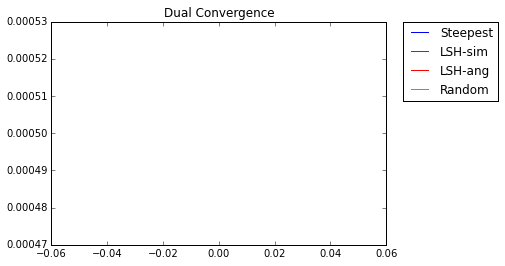

In [24]:
plt.plot(duals,label = 'Steepest')
plt.plot(duals_ls,label = 'LSH-sim')
plt.plot(duals_la,label = 'LSH-ang')
plt.plot(duals_r,label = 'Random')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Dual Convergence')

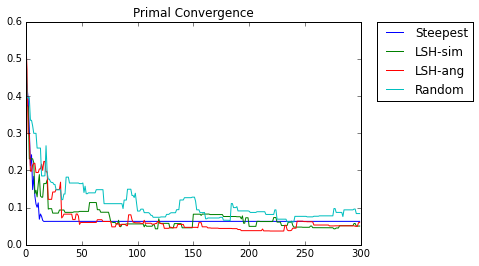

In [6]:
plt.plot(primals,label = 'Steepest')
plt.plot(primals_ls,label = 'LSH-sim')
plt.plot(primals_la,label = 'LSH-ang')
plt.plot(primals_r,label = 'Random')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Primal Convergence')

In [83]:
?np.minimum

In [20]:
1/np.linalg.norm(w)

0.15343659434050191

In [22]:
1/np.linalg.norm(w_ls)

0.14428502446989006

In [38]:
primal_func(w_ls,y,X,lambd)

0.033512943019157269

In [40]:
primal_func(w,y,X,lambd)

0.033512943019159691